In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
import numpy as np
import glob
from scipy import stats
import math

In [2]:
cd CSVs

/Users/racheldilley/Documents/Metis/git_repos/mta-project-1/CSVs


#### Load Data

In [179]:
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
data = pd.concat([pd.read_csv(f) for f in all_filenames ])

ValueError: No objects to concatenate

## Clean Data

remove spaces from column names

In [4]:
data.columns = data.columns.str.replace(' ', '')

add Date_Time column 

In [5]:
data['Date_Time'] = pd.to_datetime(data['DATE'], cache=True) + pd.to_timedelta(data['TIME'])

Add Turnstile (Combining SCP,C/A, Station and Unit) and Weekday column

In [6]:
data['Turnstile'] = data['C/A'] + data['UNIT'] + data['SCP'] + data['STATION']
data['DATE'] = pd.to_datetime(data['DATE'], cache=True)
data['Week_Day'] = data['DATE'].dt.day_name()

Only look at regular data

In [7]:
data = data[data.DESC == 'REGULAR']
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,00:00:00,REGULAR,7053483,2390505,2019-05-11 00:00:00,A002R05102-00-0059 ST,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday


#### Find total traffic

Add shifted columns to show previous entries and exits

In [8]:
#All turnstiles have cumulative counts, previous data needs to be subtraced from current data 
#to find total entries/exits
grouped_time=data.copy()
grouped_time["PREV_TIME"] = data.groupby(["Turnstile"]).TIME.shift(1)
grouped_time["PREV_EXITS"] = data.groupby(["Turnstile"]).EXITS.shift(1)
grouped_time["PREV_ENTRIES"] = data.groupby(["Turnstile"]).ENTRIES.shift(1)
grouped_time.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES
206852,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,05:00:00,REGULAR,5554,376,2019-05-03 05:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,01:00:00,376.0,5554.0
206853,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,09:00:00,REGULAR,5554,376,2019-05-03 09:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,05:00:00,376.0,5554.0
206854,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,13:00:00,REGULAR,5554,376,2019-05-03 13:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,09:00:00,376.0,5554.0
206855,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,17:00:00,REGULAR,5554,376,2019-05-03 17:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,13:00:00,376.0,5554.0
206856,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,21:00:00,REGULAR,5554,376,2019-05-03 21:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,17:00:00,376.0,5554.0


In [9]:
#drop first row of each turnstile b/c of shift down
grouped_time.dropna(subset=["PREV_ENTRIES"], axis=0, inplace=True)
grouped_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,00:00:00,2390505.0,7053483.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,04:00:00,2390508.0,7053511.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,08:00:00,2390536.0,7053534.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,12:00:00,2390596.0,7053618.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,20:00:00,REGULAR,7054133,2390702,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,16:00:00,2390655.0,7053841.0


Remove counter errors from total entries/exits that occur from counters resetting

In [10]:
def get_daily_counts_exits(row, max_counter):
    counter_ex = row["EXITS"] - row["PREV_EXITS"]
    if counter_ex < 0:
        # Maybe counter is reversed?
        counter_ex = -counter_ex
    if counter_ex > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter_ex = min(row["EXITS"], row["PREV_EXITS"])
    if counter_ex > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ex

def get_daily_counts_entries(row, max_counter):
    counter_ent = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter_ent < 0:
        # Maybe counter is reversed?
        counter_ent = -counter_ent
    if counter_ent > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter_ent = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter_ent > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ent


# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!

In [11]:
grouped_time["TOTAL_ENTRIES"] = grouped_time.apply(get_daily_counts_entries, axis=1, max_counter=100000)
grouped_time["TOTAL_EXITS"] = grouped_time.apply(get_daily_counts_exits, axis=1, max_counter=100000)
grouped_time.describe()

,ENTRIES,EXITS,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS
count,2.236073e+06,2.236073e+06,2.236073e+06,2.236073e+06,2.236073e+06,2.236073e+06
mean,4.148039e+07,3.396750e+07,3.396821e+07,4.148122e+07,6.120600e+02,4.912548e+02
std,2.118498e+08,1.951475e+08,1.951484e+08,2.118507e+08,4.711624e+03,4.015928e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.499730e+05,1.430240e+05,1.430260e+05,3.499680e+05,1.000000e+01,9.000000e+00
50%,2.176565e+06,1.254667e+06,1.254664e+06,2.176577e+06,7.600000e+01,5.500000e+01
75%,6.780894e+06,4.604451e+06,4.604462e+06,6.780916e+06,2.520000e+02,1.760000e+02
max,2.129395e+09,2.124196e+09,2.124196e+09,2.129395e+09,9.997500e+04,9.999600e+04


In [12]:
#find total traffic
grouped_time["TOTAL_TRAFFIC"] = grouped_time["TOTAL_EXITS"] + grouped_time["TOTAL_ENTRIES"]
grouped_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,00:00:00,2390505.0,7053483.0,28.0,3.0,31.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,04:00:00,2390508.0,7053511.0,23.0,28.0,51.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,08:00:00,2390536.0,7053534.0,84.0,60.0,144.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,12:00:00,2390596.0,7053618.0,223.0,59.0,282.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,20:00:00,REGULAR,7054133,2390702,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,16:00:00,2390655.0,7053841.0,292.0,47.0,339.0


remove total traffic outliers that are 3 sigmas from mean

In [13]:
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time['TOTAL_TRAFFIC'])) < 3)] #filtering
grouped_time.describe()

,ENTRIES,EXITS,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
count,2.212235e+06,2.212235e+06,2.212235e+06,2.212235e+06,2.212235e+06,2.212235e+06,2.212235e+06
mean,4.145657e+07,3.392900e+07,3.393014e+07,4.145877e+07,2.111534e+02,1.666225e+02,3.777759e+02
std,2.117360e+08,1.950153e+08,1.950168e+08,2.117418e+08,6.844930e+02,5.832379e+02,1.089409e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.461120e+05,1.405950e+05,1.405980e+05,3.462060e+05,1.000000e+01,8.000000e+00,2.900000e+01
50%,2.166457e+06,1.246360e+06,1.246475e+06,2.166594e+06,7.400000e+01,5.300000e+01,1.740000e+02
75%,6.771164e+06,4.591253e+06,4.591504e+06,6.771260e+06,2.440000e+02,1.700000e+02,4.640000e+02
max,2.129395e+09,2.124196e+09,2.124196e+09,2.129395e+09,2.481100e+04,2.474800e+04,2.482000e+04


drop uneeded columns

In [14]:
grouped_time.drop(['C/A','UNIT','SCP','LINENAME','DESC', 'ENTRIES', 'EXITS', 'PREV_TIME', 'PREV_ENTRIES', 'PREV_EXITS', 'TOTAL_ENTRIES', 'TOTAL_EXITS'], axis=1, inplace=True)

### Add Location and Income data

load location data to get borough info and latitude/longitude information

In [135]:
loc_df = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
#print(loc_data.Borough.unique())
#loc_df.tail()
#print(loc_df[loc_df['GTFS Latitude']== 40.750580])

In [136]:
#add borough_name column
burough_dict = { 'Q': 'Queens', 'M': 'Manhattan', 'Bk':'Brooklyn', 'Bx': 'Bronx', 'SI': 'Staten Island'}
loc_df['Borough_Name'] = loc_df['Borough'].map(burough_dict)

In [137]:
#drop uneeded columns
loc_df.drop(['Borough','Line','Station ID','Complex ID', 'GTFS Stop ID', 'Line', 'Structure', 
               'Daytime Routes', 'North Direction Label', 'South Direction Label', 'ADA', 'ADA Notes'], axis=1, inplace =True)

Rename columns in loc_data to merge on STATION and DIVISION

In [138]:
#stations were found to have the same but located in diff areas so DIVISION was also used
loc_df.rename(columns = {'Stop Name':'STATION', 'Division':'DIVISION','GTFS Latitude':'Latitude','GTFS Longitude':'Longitude'}, inplace = True) 
loc_df['STATION'] = loc_df['STATION'].str.upper()
#replace some strings in loc_df to match grouped_time station names
loc_df['STATION'] = loc_df['STATION'].str.replace('STATION', 'STA')
loc_df['STATION'] = loc_df['STATION'].str.replace('GRAND CENTRAL', 'GRD CNTRL')
loc_df['STATION'] = loc_df['STATION'].str.replace('42 ST-PORT AUTHORITY BUS TERMINAL', '42 ST-PORT AUTH')
#join with grouped_time
station_loc_df = grouped_time.merge(loc_df, how = 'inner', on = ['STATION'])
#station_loc_df.tail()
#print(station_loc_df[station_loc_df['STATION']=='28 ST'])
#print(station_loc_df[station_loc_df['STATION']=='34 ST-PENN STA'])

Add income data

In [143]:
#import income data
income_data = pd.read_csv('https://raw.githubusercontent.com/hollyyuqizheng/transportation-transformation/master/data/new_york/new%20york%20income%20data.csv')
#print(loc_data.Borough.unique())
#income_data.head()

In [111]:
#new df grouped by latitude, longitude, and station
station_lat_long_df = station_loc_df.groupby(['Latitude','Longitude', 'STATION','Borough_Name'], as_index=False ).TOTAL_TRAFFIC.sum()
station_lat_long_df.drop_duplicates('STATION',keep='first', inplace=True)
#print(station_lat_long_df[station_lat_long_df['STATION']=='28 ST'])

Find average income for each station

In [112]:
def find_min_dist(row):
    '''
    row from station_income_df as argument
    loop through income_df to find closest zip code based on latitude and longitude
    return Avg income of closest zip code to station
    '''
    min_dist = 1000
    idx = 0
    for index, r in income_data.iterrows():
        l = r[1].split(", ")
        l = [float(i) for i in l]
        a = ((l[0] - row['Latitude'])**2 + (l[1] - row['Longitude'])**2)
        a = abs(a)
        dist = math.sqrt(a)
        if dist < min_dist:
            min_dist = dist
            idx = index
    return income_data.iloc[idx]['Avg. Income/H/hold']

In [155]:
#new df that includes station income, location, and traffic info
station_income_df = station_lat_long_df.copy()
#apply function to find income info based on location, sort data by decreasing incomes
station_income_df['Avg_Income'] = station_income_df.apply(find_min_dist, axis=1) 
station_income_df.sort_values('Avg_Income', ascending=False, inplace=True)
#avg income in the thousands
station_income_df['Avg_Income'] = station_income_df['Avg_Income']/1000 
#print(station_income_df)

In [156]:
#find total income of all stations
total_income = station_income_df['Avg_Income'].sum()

new df with income and traffic data sorted by traffic

In [157]:
top_traffic_stations_df = station_income_df.copy()
top_traffic_stations_df = top_traffic_stations_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']]
top_traffic_stations_df.sort_values('TOTAL_TRAFFIC', ascending=False, inplace=True)
#total traffic in the millions
top_traffic_stations_df['TOTAL_TRAFFIC'] = top_traffic_stations_df['TOTAL_TRAFFIC']/1000000

In [162]:
#find total traffic
total_traffic = top_traffic_stations_df['TOTAL_TRAFFIC'].sum()

new dfs for top 50 income and traffic, and income/traffic combined 

In [163]:
#find incoem and traffic percentiles by dividing income/traffic by total income/traffic across all stations
top50_income = station_income_df.head(50)
top50_income['Income_Percentile'] = (top50_income['Avg_Income']/total_income)*100

top50_traffic = top_traffic_stations_df.head(50)
top50_traffic['Traffic_Percentile'] = (top50_traffic['TOTAL_TRAFFIC']/total_traffic)*100

#drop uneeded columns before merging
top50_income.drop([ 'Avg_Income'], axis=1, inplace=True)
top50_traffic.drop([ 'Avg_Income'], axis=1, inplace=True)

<ipython-input-163-1b0bd960d1e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_income['Income_Percentile'] = (top50_income['Avg_Income']/total_income)*100
<ipython-input-163-1b0bd960d1e0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_traffic['Traffic_Percentile'] = (top50_traffic['TOTAL_TRAFFIC']/total_traffic)*100


In [164]:
#new df containing stations in both the top 50 income and top 50 traffic
top_50_df = top50_income.merge(top50_traffic, how = 'inner', on = ['STATION', 'Borough_Name'])

#new total percentile col and sort df by decreasing total percentile
top_50_df['Total_Percentile'] = top_50_df['Traffic_Percentile'] + top_50_df['Income_Percentile']
top_50_df.sort_values('Total_Percentile', ascending=False, inplace=True)

In [165]:
#new df stations with containing top 10 total percentiles
top10_rank_df = top_50_df.head(10)

## Top Traffic Stations Based on Income and Traffic

### Top 10 Highest Trafffic Stations

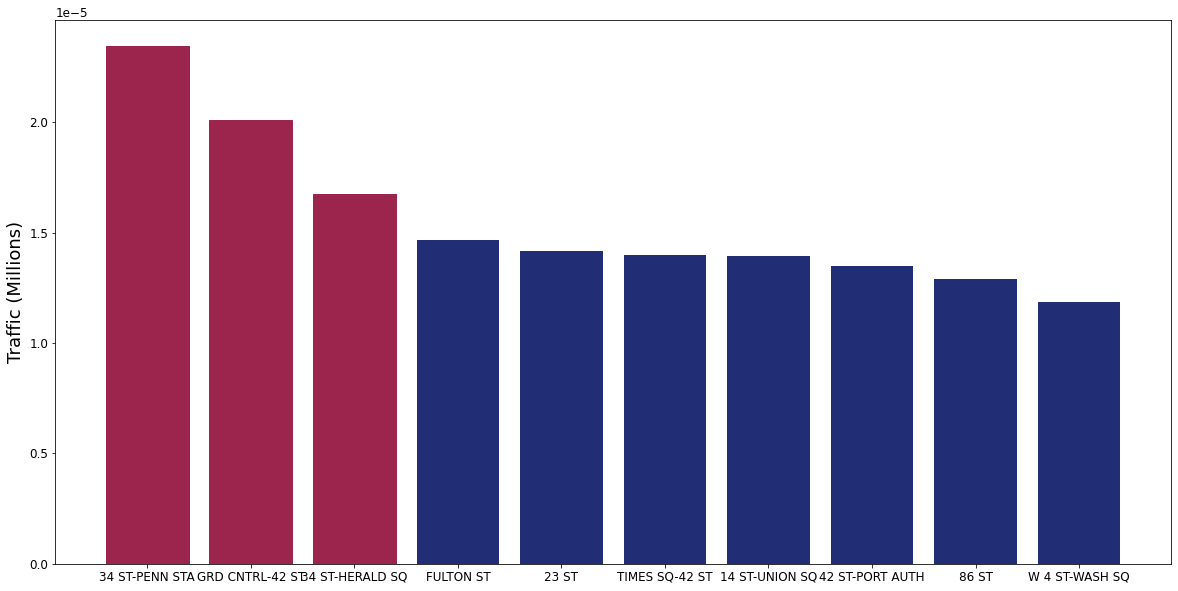

In [178]:
plt.rcParams['font.size']= 12
#only need top 10
top10_station_traffic_df = top_traffic_stations_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']].head(10)

#income in thousands, traffic in millions
top10_station_traffic_df['Avg_Income'] = top10_station_traffic_df['Avg_Income']/1000
top10_station_traffic_df['TOTAL_TRAFFIC'] = top10_station_traffic_df['TOTAL_TRAFFIC']/1000000

#plot
top_traf_bar = plt.bar(top10_station_traffic_df['STATION'], top10_station_traffic_df['TOTAL_TRAFFIC'], color='#212d74')
plt.ylabel("Traffic (Millions)",fontsize=18)

#highlight stations in with top 10 incomes and traffic
top_traf_bar[0].set_color('#9c254d')
top_traf_bar[1].set_color('#9c254d')
top_traf_bar[2].set_color('#9c254d')

#plt.savefig('top10_traf_bar.png', dpi=300)
plt.show()

### Top 10 Stations in Highest Income Areas

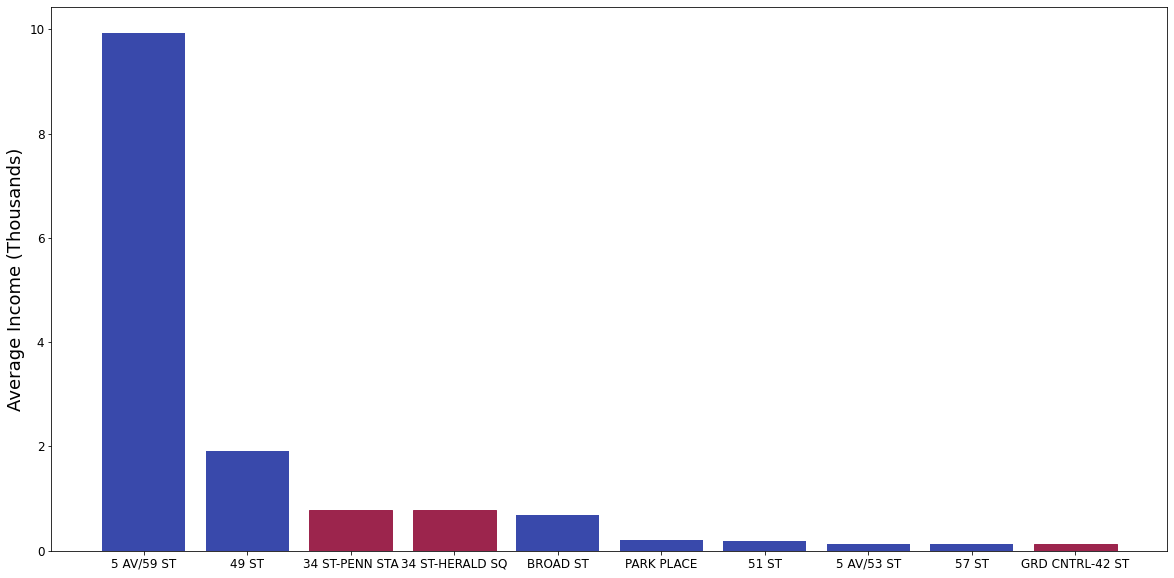

In [177]:
plt.rcParams['font.size']= 12
#only need top 10
top_station_income_df = station_income_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']].head(10)

#income in thousands, traffic in millions
top_station_income_df['Avg_Income'] = top_station_income_df['Avg_Income']/1000
top_station_income_df['TOTAL_TRAFFIC'] = top_station_income_df['TOTAL_TRAFFIC']/1000000

#plot
top_inc_bar = plt.bar(top_station_income_df['STATION'], top_station_income_df['Avg_Income'], color='#3949ab')
plt.ylabel("Average Income (Thousands)",fontsize=18)

#highlight stations in with top 10 incomes and traffic
top_inc_bar[3].set_color('#9c254d')
top_inc_bar[2].set_color('#9c254d')
top_inc_bar[9].set_color('#9c254d')

#plt.savefig('top10_inc_bar.png', dpi=300)
plt.show()

### Top 10 stations for both Income and Traffic 

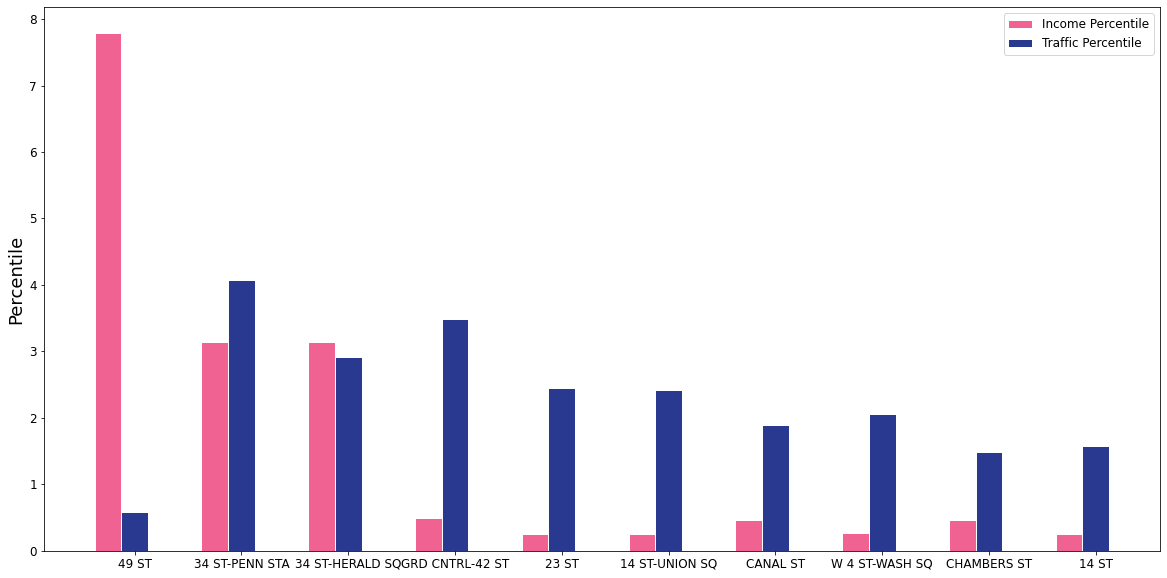

In [171]:
barWidth = 0.25
r1 = np.arange(len(top10_rank_df['STATION']))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1,top10_rank_df['Income_Percentile'], color= '#f06292', width=barWidth, edgecolor='white', label='Income Percentile')
plt.bar(r2, top10_rank_df['Traffic_Percentile'], color='#2a3990', width=barWidth, edgecolor='white', label='Traffic Percentile')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(top10_rank_df['Traffic_Percentile']))], top10_rank_df['STATION'])
 
plt.rcParams['font.size']= 12
plt.ylabel("Percentile",fontsize=18)
plt.legend()
#plt.savefig('top10_rank_bar.png', dpi=300)
plt.show()

## Compare Boroughs

### Graph number of stations in each borough

<BarContainer object of 5 artists>

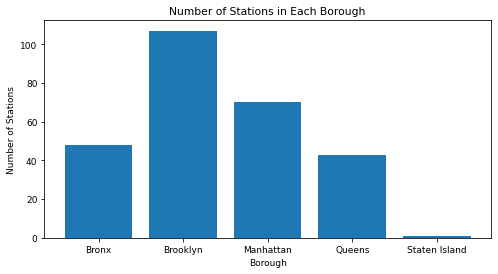

In [139]:
borough_station_count_df = station_loc_df.groupby('Borough_Name')['STATION'].nunique().reset_index()
plt.rcParams["figure.figsize"] = (8, 4)
plt.xlabel("Borough")
plt.ylabel("Number of Stations")
plt.title("Number of Stations in Each Borough")
plt.bar(borough_station_count_df['Borough_Name'], borough_station_count_df['STATION'])

### Graph total traffic in each Borough 

<BarContainer object of 5 artists>

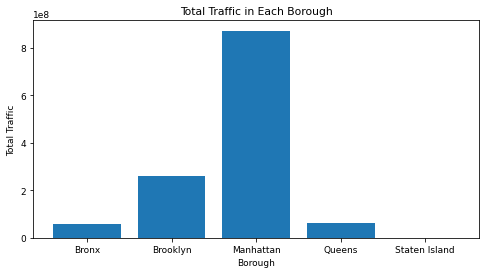

In [140]:
borough_traffic_df = station_loc_df.groupby('Borough_Name').TOTAL_TRAFFIC.sum().reset_index()
plt.xlabel("Borough")
plt.ylabel("Total Traffic")
plt.title("Total Traffic in Each Borough")
plt.bar(borough_traffic_df['Borough_Name'], borough_traffic_df['TOTAL_TRAFFIC'])

### Find top 5 stations in each borough and graph

In [141]:
#bew df with top 5 in each borough by traffic sorted
borough_top5_df = station_loc_df.groupby(['Borough_Name','STATION']).agg({'TOTAL_TRAFFIC':'sum'}, asindex=False)
borough_top5_df = borough_top5_df['TOTAL_TRAFFIC'].groupby('Borough_Name', group_keys=False)
borough_top5_df = borough_top5_df.apply(lambda x: x.sort_values(ascending=False).head(5))
borough_top5_df

Borough_Name   STATION        
Bronx          FORDHAM RD          5020206.0
               167 ST              4645166.0
               KINGSBRIDGE RD      4505952.0
               170 ST              4130198.0
               GUN HILL RD         3450604.0
Brooklyn       86 ST              25797912.0
               CHURCH AV          15777033.0
               FULTON ST          14657662.0
               KINGS HWY          12601506.0
               7 AV               10612046.0
Manhattan      23 ST              70800200.0
               CANAL ST           65664786.0
               GRD CNTRL-42 ST    60331374.0
               FULTON ST          58630648.0
               TIMES SQ-42 ST     55958712.0
Queens         111 ST              6122097.0
               WOODHAVEN BLVD      6089928.0
               COURT SQ            5935204.0
               36 ST               2846419.0
               JUNCTION BLVD       2838276.0
Staten Island  TOMPKINSVILLE        247600.0
Name: TOTAL_TRAFFIC, dty

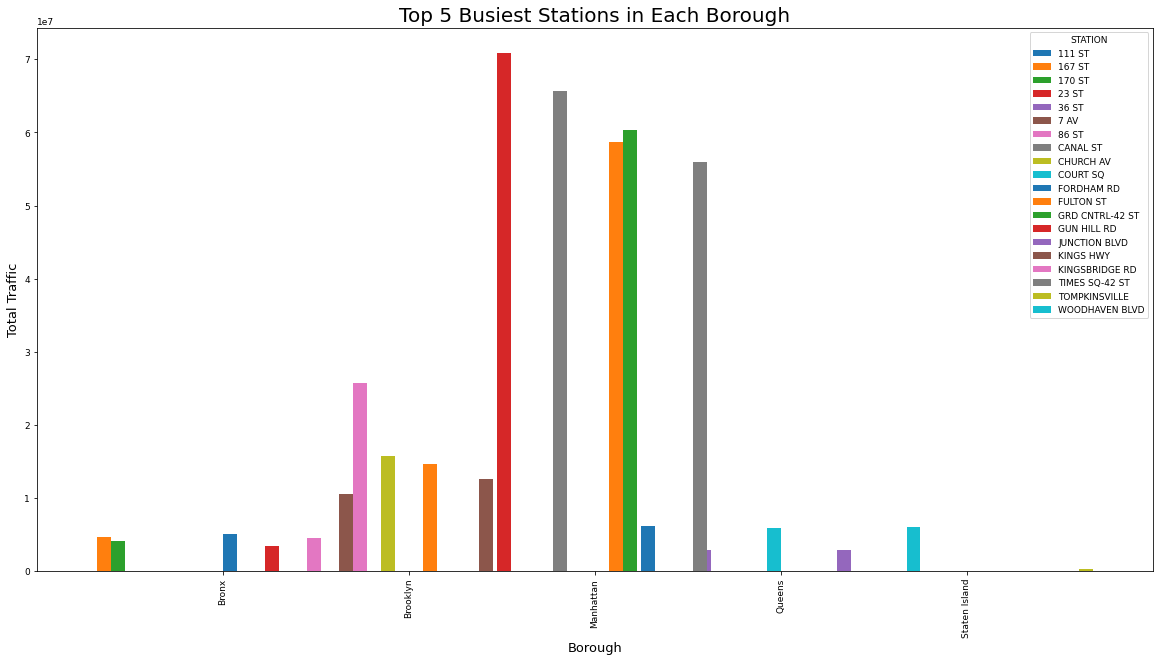

In [142]:
rcParams['figure.figsize'] = 20,10
borough_top5_df.unstack().plot.bar(width=1.5)
#plt.bar([0,2,3,4],borough_top5_df.unstack(),width=1.5)
#plt.bar(borough_top5_df.unstack(),width=1.5)
plt.title("Top 5 Busiest Stations in Each Borough", fontsize=20)
plt.ylabel("Total Traffic",fontsize=13)
plt.xlabel("Borough",fontsize=13)
plt.rcParams.update({'font.size': 9})
#plt.tight_layout()
 
#borough_top5_df.unstack().plot.bar()

### Find high traffic days

In [45]:
#find max and min of lat and long
BBox = (station_lat_long_df.Longitude.min(),   station_lat_long_df.Longitude.max(),      
         station_lat_long_df.Latitude.min(), station_lat_long_df.Latitude.max())
BBox

(-74.074835, -73.761353, 40.576312, 40.898379)

In [ ]:
cd - 

In [ ]:
ruh_m = plt.imread('NYC_Map.png') #load NYC Map

In [ ]:
fig, ax = plt.subplots(figsize = (11,10))
ax.scatter(station_lat_long_df.Longitude, station_lat_long_df.Latitude, zorder=1, alpha= 0.2, c='b', s=15)
ax.set_title('Plotting Stations in NYC')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')